We are trying to predict data traffic movement from nearby cells 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, GRU, Conv1D, Dropout, GlobalAvgPool1D, MaxPool1D
from sklearn.preprocessing import MinMaxScaler

,1ALTE,1BLTE,1CLTE,2ALTE,3ALTE,3BLTE,3CLTE,4ALTE,4BLTE,4CLTE,5ALTE,5BLTE,5CLTE
1ALTE,1.000000,0.270262,0.159466,0.088597,0.313846,0.152227,0.317344,0.271379,0.453701,0.162706,0.323942,0.419159,0.427966
1BLTE,0.270262,1.000000,0.289001,0.059541,0.206337,0.168471,0.259509,0.247286,0.322760,0.180760,0.183910,0.241215,0.263671
1CLTE,0.159466,0.289001,1.000000,0.042606,0.153863,0.136920,0.187841,0.233094,0.302170,0.225566,0.129204,0.130734,0.235173
2ALTE,0.088597,0.059541,0.042606,1.000000,0.125897,0.027990,0.091462,0.040725,0.100747,0.016311,0.078260,0.091147,0.071682
3ALTE,0.313846,0.206337,0.153863,0.125897,1.000000,0.134527,0.299942,0.114832,0.269962,0.063910,0.366653,0.453106,0.411989
3BLTE,0.152227,0.168471,0.136920,0.027990,0.134527,1.000000,0.123067,0.107378,0.194226,0.118421,0.167428,0.173264,0.174866
3CLTE,0.317344,0.259509,0.187841,0.091462,0.299942,0.123067,1.000000,0.201062,0.369978,0.133845,0.259606,0.328446,0.335008
4ALTE,0.271379,0.247286,0.233094,0.040725,0.114832,0.107378,0.201062,1.000000,0.286555,0.136955,0.101272,0.138097,0.195666
4BLTE,0.453701,0.322760,0.302170,0.100747,0.269962,0.194226,0.369978,0.286555,1.000000,0.219111,0.302609,0.374218,0.431911
4CLTE,0.162706,0.180760,0.225566,0.016311,0.063910,0.118421,0.133845,0.136955,0.219111,1.000000,0.101010,0.096002,0.120033


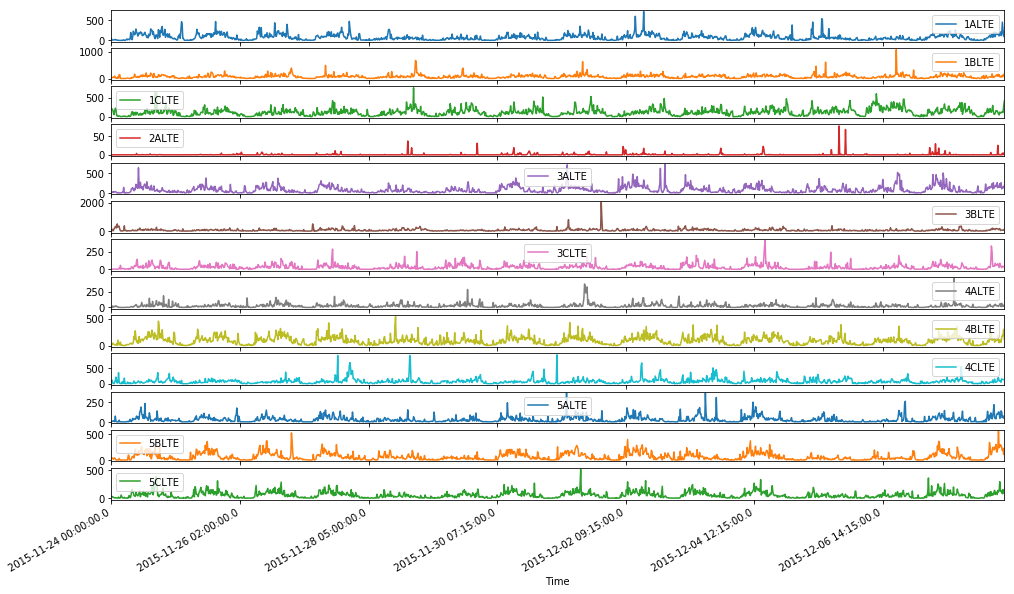

In [14]:
df = pd.read_csv('dataset.csv', header=[0], index_col=0)
df = df.dropna()

df.plot(subplots=True, figsize=(16, 10))
df.corr()

In [15]:
df.head()


,1ALTE,1BLTE,1CLTE,2ALTE,3ALTE,3BLTE,3CLTE,4ALTE,4BLTE,4CLTE,5ALTE,5BLTE,5CLTE
Time,,,,,,,,,,,,,
2015-11-24 00:00:00.0,38.900513,24.102097,218.055913,0.018605,19.241477,21.341209,0.941300,0.374617,13.034921,75.281295,4.780959,32.014656,32.610498
2015-11-24 00:15:00.0,12.768467,44.883316,199.298426,0.027094,21.594525,127.911528,0.334144,0.502799,15.934131,116.124558,12.273641,37.391993,31.493048
2015-11-24 00:30:00.0,6.687793,37.822587,182.810675,0.001415,30.678377,41.728268,3.171856,23.697071,47.089954,23.730048,5.816438,39.716055,16.764852
2015-11-24 00:45:00.0,7.525489,47.215087,102.549222,0.011040,12.864109,28.474229,2.085876,5.959848,34.875856,5.631509,9.630456,13.797997,18.900401
2015-11-24 01:00:00.0,13.247397,64.076437,55.934183,0.015583,32.237781,186.731933,1.578332,11.723243,19.944706,2.039060,16.588893,34.173211,8.971391


In [16]:
df.shape

(1390, 13)

We have a multivariate timeseries classification problem. We need to structure it.

In [59]:
#suppose with want to make a prediction for "4BLTE"
# its index is 8

def split_sequences(sequences, n_steps, idx_array):
    X, target = list(), list()
    for i in range(len(sequences)):
        #find the end of the subsequence
        end_ix = i + n_steps
        if end_ix > len(sequences) - 1:
            break
        #gather input and output parts of the subsequence
        seq_x, seq_y = sequences[i:end_ix, idx_array-2:idx_array+2], sequences[end_ix, idx_array-2:idx_array+2]
        target.append(np.where(seq_x[-1, 2]<seq_y[2], 1, 0))
        X.append(seq_x)
    return np.array(X), np.array(target)
        
        

In [61]:
LOOKBACK = 128
IDX_ARRAY = 8
scaler = MinMaxScaler()
series = scaler.fit_transform(df.values)
X, y = split_sequences(series, n_steps=LOOKBACK, idx_array=IDX_ARRAY )


In [62]:
def create_model():
    inputs = Input(shape=X.shape[1:])
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(2, activation='softmax')(x)
    mlp = Model(inputs ,out)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return mlp


Train on 1009 samples, validate on 253 samples
Epoch 1/50
1009/1009 [==============================] - 2s 2ms/step - loss: 0.7086 - acc: 0.5055 - val_loss: 0.6908 - val_acc: 0.4941
Epoch 2/50
1009/1009 [==============================] - 0s 64us/step - loss: 0.7155 - acc: 0.4916 - val_loss: 0.6924 - val_acc: 0.4862
Epoch 3/50
1009/1009 [==============================] - 0s 57us/step - loss: 0.7028 - acc: 0.5094 - val_loss: 0.6923 - val_acc: 0.5257
Epoch 4/50
1009/1009 [==============================] - 0s 64us/step - loss: 0.6929 - acc: 0.5411 - val_loss: 0.6916 - val_acc: 0.5494
Epoch 5/50
1009/1009 [==============================] - 0s 58us/step - loss: 0.6926 - acc: 0.5154 - val_loss: 0.6917 - val_acc: 0.5178
Epoch 6/50
1009/1009 [==============================] - 0s 61us/step - loss: 0.6913 - acc: 0.5233 - val_loss: 0.6910 - val_acc: 0.5375
Epoch 7/50
1009/1009 [==============================] - 0s 65us/step - loss: 0.6985 - acc: 0.4995 - val_loss: 0.6932 - val_acc: 0.4743
Epoch 8/5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7fbae3630>,
      dtype=object)

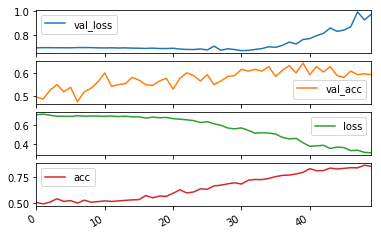

In [63]:
mlp = create_model()
history = mlp.fit(X, y, epochs=50, validation_split=0.2)

history = pd.DataFrame(history.history)
history.plot(subplots=True)

In [48]:
#Kfold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


kf = KFold(n_splits=10)
#for train_index, test_index in kf.split(X):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    mlp.fit(X_train, y_train, epochs = 10)

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=64, verbose=0)

scores = cross_val_score(model, X, y, cv=kf)

avg_score = np.mean(scores)
print(avg_score)

0.5829085451436007


Train on 1009 samples, validate on 253 samples
Epoch 1/25
1009/1009 [==============================] - 6s 6ms/step - loss: 0.6940 - acc: 0.4896 - val_loss: 0.6925 - val_acc: 0.4901
Epoch 2/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6930 - acc: 0.5164 - val_loss: 0.6927 - val_acc: 0.5336
Epoch 3/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6922 - acc: 0.5401 - val_loss: 0.6911 - val_acc: 0.5850
Epoch 4/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6904 - acc: 0.5461 - val_loss: 0.6877 - val_acc: 0.5810
Epoch 5/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6903 - acc: 0.5243 - val_loss: 0.6881 - val_acc: 0.5573
Epoch 6/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6808 - acc: 0.5818 - val_loss: 0.6775 - val_acc: 0.5375
Epoch 7/25
1009/1009 [==============================] - 4s 4ms/step - loss: 0.6766 - acc: 0.5629 - val_loss: 0.6621 - val_acc: 0.6324
Epoch 8/25
1009

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7fa0dda20>,
      dtype=object)

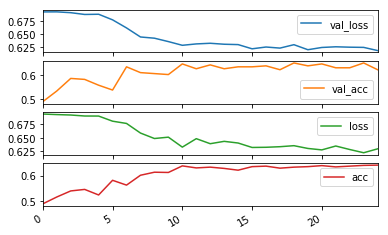

In [64]:
inputs = Input(shape=X.shape[1:])
x = GRU(64, activation='relu', dropout=0.1, return_sequences=True)(inputs)
x = GRU(64, activation='relu', dropout=0.1, return_sequences=False)(x)

x = Dense(32,activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(2, activation='softmax')(x)
lstm = Model(inputs ,out)
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(X, y, epochs=25, validation_split=0.2)

history = pd.DataFrame(history.history)
history.plot(subplots=True)

Train on 926 samples, validate on 232 samples
Epoch 1/10
926/926 [==============================] - 1s 1ms/step - loss: 0.6949 - acc: 0.4935 - val_loss: 0.6933 - val_acc: 0.4741
Epoch 2/10
926/926 [==============================] - 0s 66us/step - loss: 0.6925 - acc: 0.5173 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 3/10
926/926 [==============================] - 0s 62us/step - loss: 0.6909 - acc: 0.5270 - val_loss: 0.6938 - val_acc: 0.5172
Epoch 4/10
926/926 [==============================] - 0s 63us/step - loss: 0.6905 - acc: 0.5400 - val_loss: 0.6958 - val_acc: 0.4871
Epoch 5/10
926/926 [==============================] - 0s 70us/step - loss: 0.6869 - acc: 0.5551 - val_loss: 0.6948 - val_acc: 0.5129
Epoch 6/10
926/926 [==============================] - 0s 62us/step - loss: 0.6820 - acc: 0.5724 - val_loss: 0.6960 - val_acc: 0.5345
Epoch 7/10
926/926 [==============================] - 0s 62us/step - loss: 0.6776 - acc: 0.5745 - val_loss: 0.7031 - val_acc: 0.5172
Epoch 8/10
926/926 [====

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff802517550>,
      dtype=object)

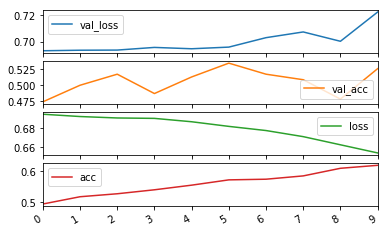

In [46]:
inputs = Input(shape=X.shape[1:])
x = Conv1D(64, 16, activation='relu', )(inputs)
x = MaxPool1D(4)(x)
x = Conv1D(64, 4, activation='relu', )(x)
#x = MaxPool1D(2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
out = Dense(2, activation='softmax')(x)
lstm = Model(inputs ,out)
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(X, y, epochs=10, validation_split=0.2)

history = pd.DataFrame(history.history)
history.plot(subplots=True)